#### code to plot the fluxes vs SST and height
#### author CLaudia Acquistapace
#### goal: plot fluxes SHF and LHF
#### date: 10/12/2021
#### edited: A. N. Meroni, 02 Feb 2022: added the uncertainty in the figure


In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
#import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
#import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [5]:
data = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_sst_3.nc')

#data = xr.open_dataset('/home/agostino/SST-impact_data/arthus_binned_sst_3.nc')
LHF = data.LHF.values
SHF = data.SHF.values
sst = data.sst.values
height = data.height.values

In [6]:
data


<xarray.Dataset>
Dimensions:  (height: 57, sst: 55)
Coordinates:
  * sst      (sst) float64 26.28 26.31 26.33 26.36 ... 27.56 27.58 27.61 27.63
  * height   (height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
Data variables:
    T        (sst, height) float64 ...
    T_std    (sst, height) float64 ...
    T_n      (sst, height) int64 ...
    MR       (sst, height) float64 ...
    MR_std   (sst, height) float64 ...
    MR_n     (sst, height) int64 ...
    VW       (sst, height) float64 ...
    VW_std   (sst, height) float64 ...
    VW_n     (sst, height) int64 ...
    LHF      (sst, height) float64 4.3 -0.326 -11.27 17.81 ... -42.32 nan nan
    LHF_std  (sst, height) float64 ...
    LHF_n    (sst, height) int64 ...
    SHF      (sst, height) float64 -16.15 -18.51 14.99 14.65 ... nan nan nan nan
    SHF_std  (sst, height) float64 ...
    SHF_n    (sst, height) int64 ...
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-01-20 10:16:23.182726
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Sensible heat fluxwith the diurnal cycle removed from ...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           original data postprocessed by Diego Lange

In [25]:
# definition of a function to calculate the uncertainty propagation


def f_uncertainty_prop(data, sigma_o, n_days, n_sigma, varstring):
    
    ''' function to propagate the uncertainty in the measurement and calculate the non-significative bins)
    inputs:
    - data: xarray dataset of data to be plotted
    - sigma_o: initial uncertainty in the data to be provided 
    - n_days: number of days used for the computation of the diurnal cycle
    - n_sigma: number of sigma chosen to check whether the measurement is different than zero.
    - varstring: string identifying the variable name
    outputs: 
    - result : xarray with values smaller than n_sigma*sigma_shf_final masked ''' 
    
    # calculation of the uncertainty propagation
    da_sigma_final = sigma_o*np.sqrt(1+1/n_days)/np.sqrt(data[varstring+'_n'])
    sigma_final = da_sigma_final.values

    # masking the dataset
    data_m = np.ma.masked_where(np.abs(data[varstring].values)>n_sigma*sigma_final,data[varstring].values)
    
    return(data_m)


#testing the function
masked_LHF = f_uncertainty_prop(data, 25, 8, 3, 'LHF')
masked_SHF = f_uncertainty_prop(data, 50, 8, 3, 'SHF')

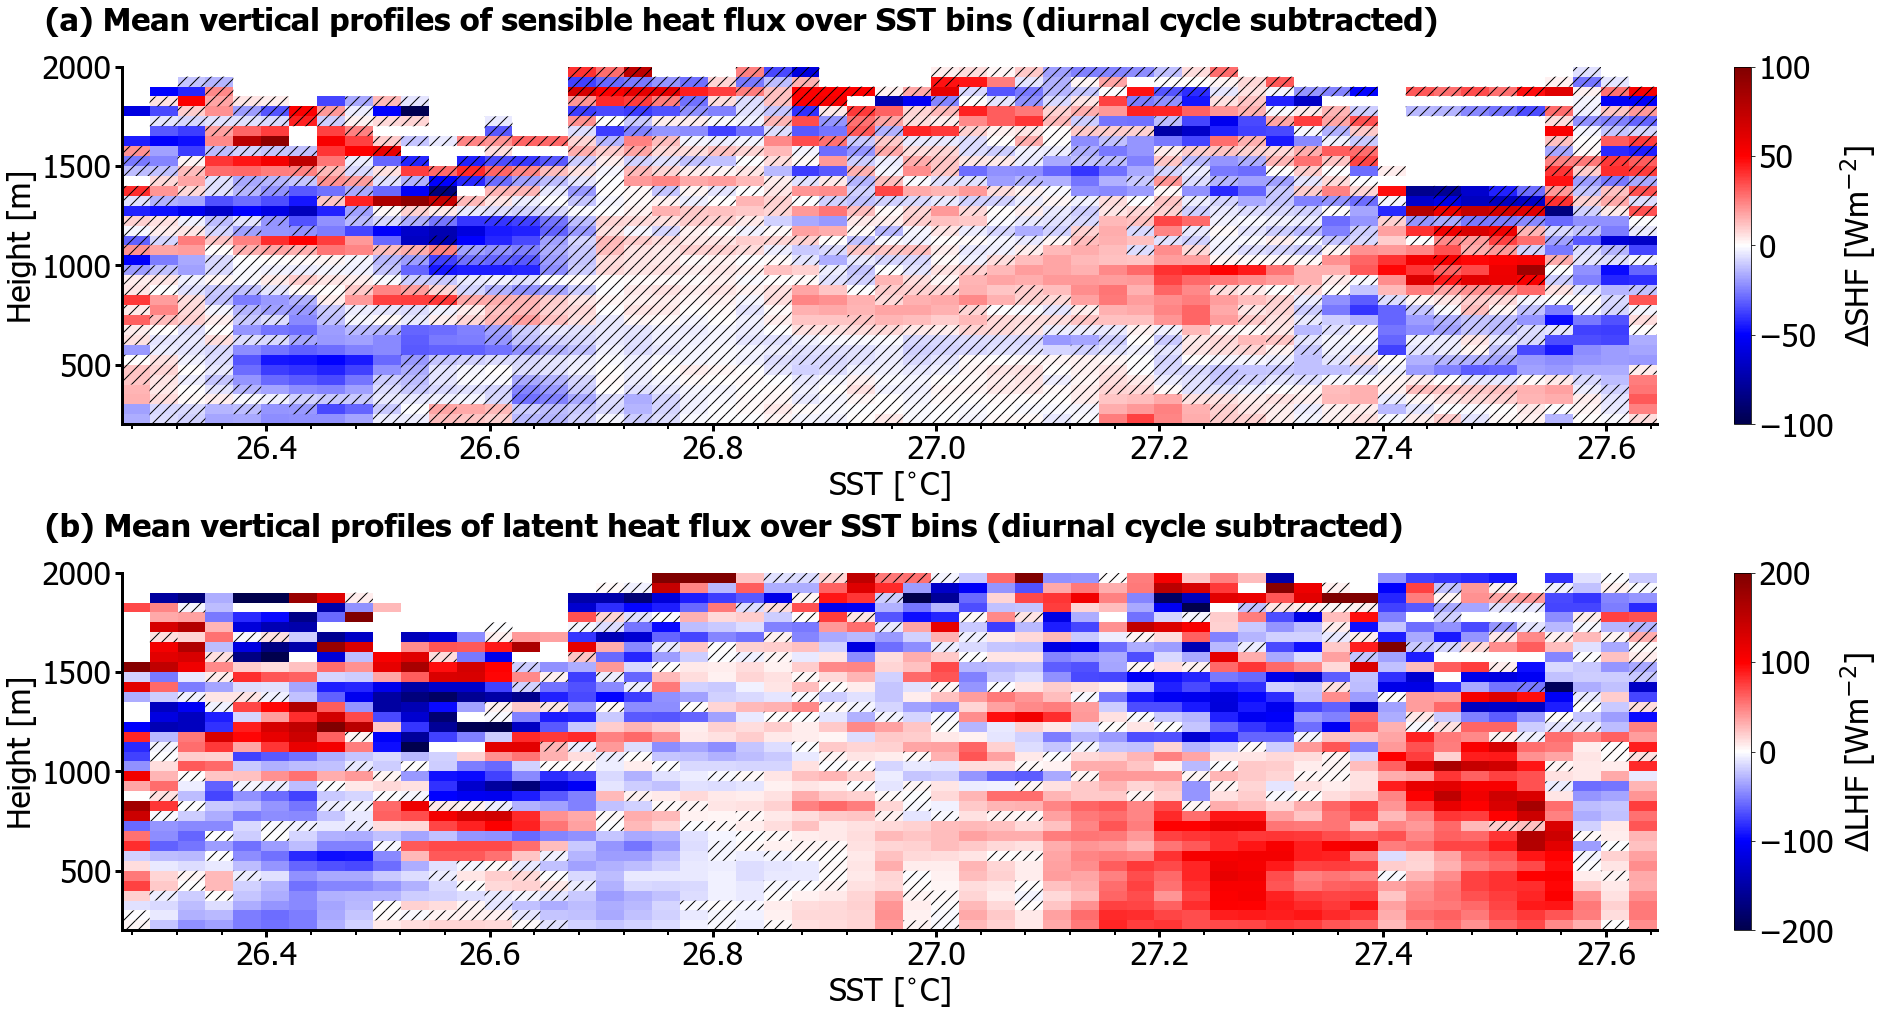

In [26]:
# plotting the masked functions
dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
#path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out_plots = '/home/agostino/SST-impact_data/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

fig, axs = plt.subplots(2,1, figsize=(26,14), constrained_layout=True)
mesh1 = axs[0].pcolormesh(sst, height, SHF.T, cmap='seismic', vmin=-100., vmax=100.)
axs[0].pcolor(sst, height, masked_SHF.T, hatch='//', alpha=0.)
cbar = fig.colorbar(mesh1, ax=axs[0])
cbar.set_label(label='$\Delta$SHF [Wm$^{-2}$]',  size=fontSizeX)

mesh2 = axs[1].pcolormesh(sst, height, LHF.T, cmap='seismic', vmin=-200., vmax=200.)
axs[1].pcolor(sst, height, masked_LHF.T, hatch='//', alpha=0.)

cbar = fig.colorbar(mesh2, ax=axs[1])
cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)
for ax, l in zip(axs[:].flatten(), ['(a) Mean vertical profiles of sensible heat flux over SST bins (diurnal cycle subtracted) ',  '(b) Mean vertical profiles of latent heat flux over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylabel('Height [m]', fontsize=fontSizeX)
    ax.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
    ax.set_ylim(200.,2000.)
#fig.savefig(path_out_plots+'figure_LHF_SHF.png', format='png')

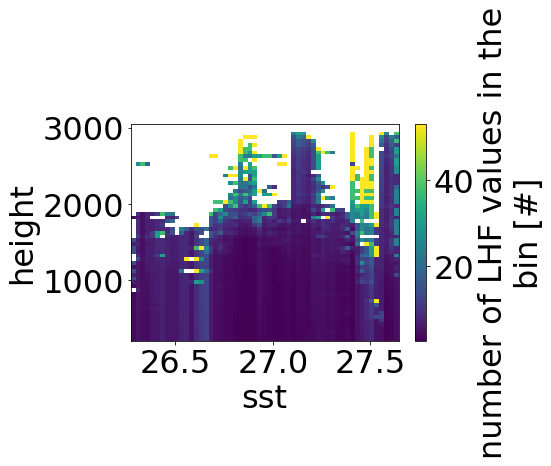

In [61]:
######## NEW ##########
# Use the number of data in each bin to propagate the uncertainty.
# Consider that, for the computation of the diurnal cycle we use 8 days (from Jan 28 to Feb 4).
ndays = 8

sigma_shf_o = 50 # Initial uncertainty -> to be set.
da_sigma_shf_final = sigma_shf_o*np.sqrt(1+1/ndays)/np.sqrt(data.SHF_n)
sigma_shf_final = da_sigma_shf_final.values

sigma_lhf_o = 50 # Initial uncertainty -> to be set.
da_sigma_lhf_final = sigma_lhf_o*np.sqrt(1+1/ndays)/np.sqrt(data.LHF_n)
da_sigma_lhf_final.plot(x='sst',y='height')
sigma_lhf_final = da_sigma_lhf_final.values

<ipython-input-62-f233754c745d>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(sst, height, SHF.T, cmap='seismic', vmin=-100., vmax=100.)
<ipython-input-62-f233754c745d>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[1].pcolormesh(sst, height, LHF.T, cmap='seismic', vmin=-200., vmax=200.)
<ipython-input-62-f233754c745d>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is dep

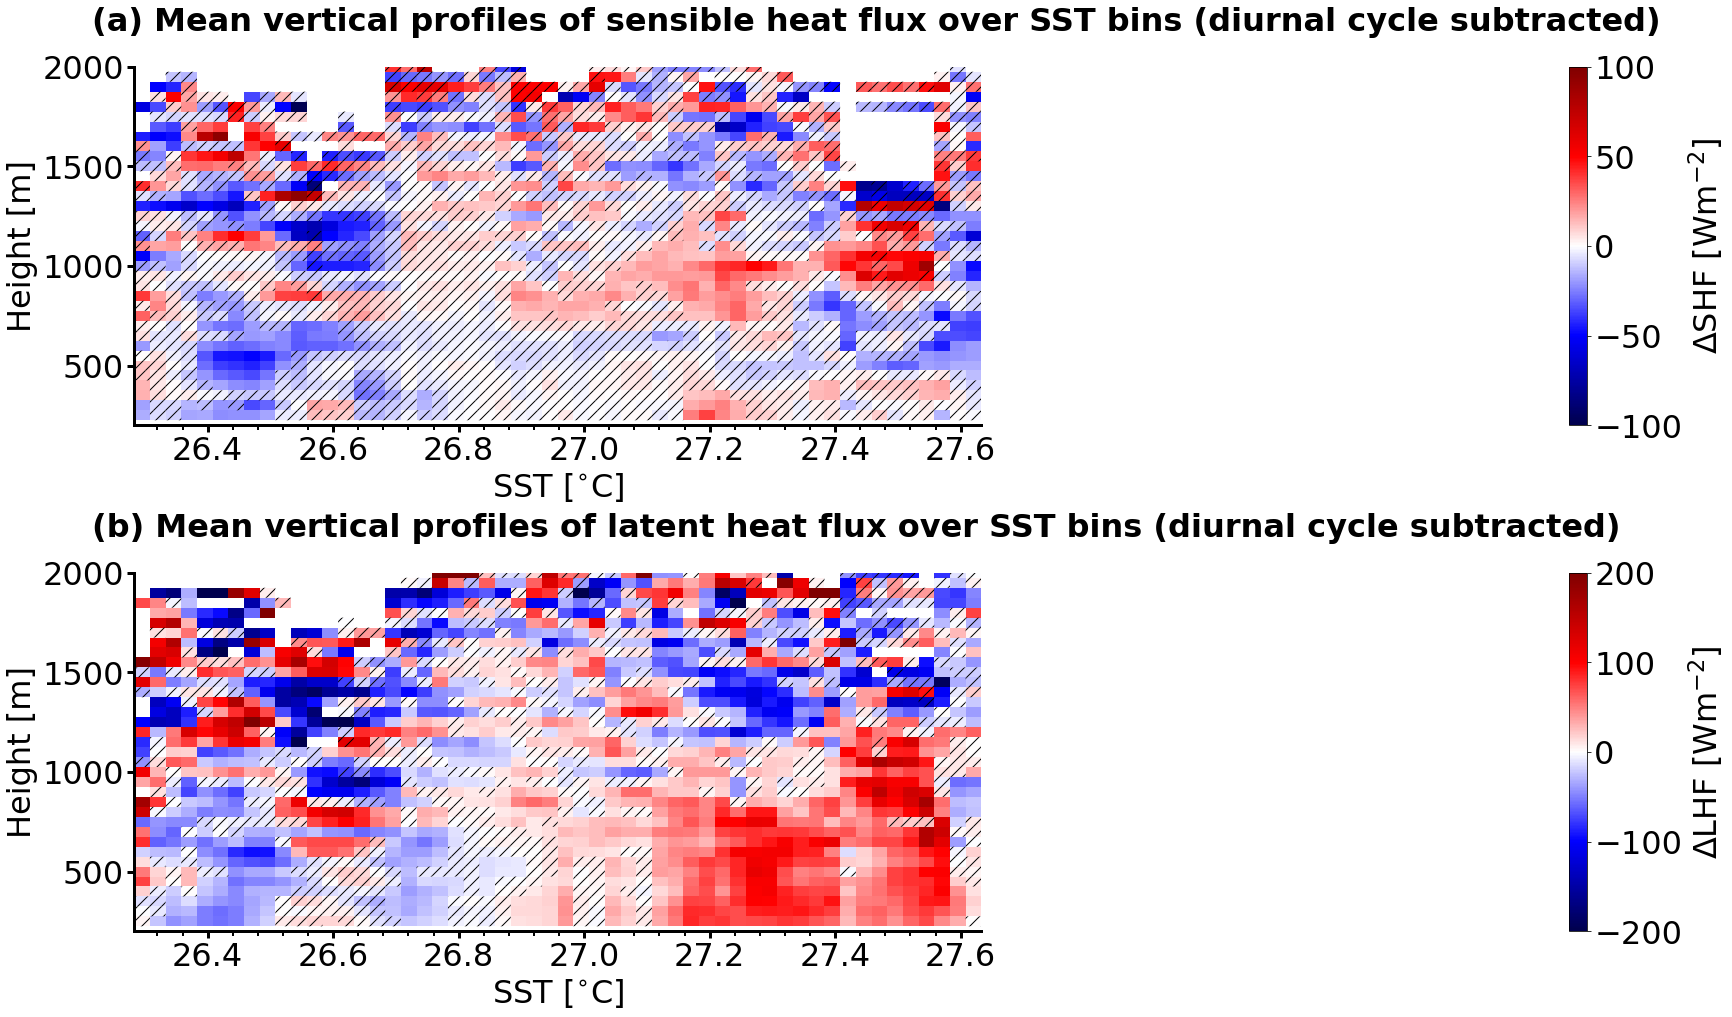

In [62]:


dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
#path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out_plots = '/home/agostino/SST-impact_data/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2,1, figsize=(24,14), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

mesh = axs[0].pcolormesh(sst, height, SHFm.T, cmap='seismic', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label(label='$\Delta$SHF [Wm$^{-2}$]',  size=fontSizeX)



mesh = axs[1].pcolormesh(sst, height, masked_LHF.T, cmap='seismic', vmin=-200., vmax=200.)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)

##### NEW #####
# Use 3 sigma to check whether the measurement is different than zero.

SHFm = np.ma.masked_where(np.abs(SHF)>3*sigma_shf_final,SHF)
axs[0].pcolor(sst, height, SHFm.T, hatch='//', alpha=0.)

LHFm = np.ma.masked_where(np.abs(LHF)>3*sigma_lhf_final,LHF)
axs[1].pcolor(sst, height, LHFm.T, hatch='//', alpha=0.)

#####

for ax, l in zip(axs[:].flatten(), ['(a) Mean vertical profiles of sensible heat flux over SST bins (diurnal cycle subtracted) ',  '(b) Mean vertical profiles of latent heat flux over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylabel('Height [m]', fontsize=fontSizeX)
    ax.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
    ax.set_ylim(200.,2000.)
fig.savefig(path_out_plots+'figure_LHF_SHF.png', format='png')